# Notebook Description

In this notebook, I attempt to use machine learning to predict whether or not a golfer will make the cut at the Masters Tournament. The models used take inputs consisting of full season aggregate statistics from the previous year to make the predictions for that year's Masters Tournament (e.g., the models used 2018 full season data to predict 2019 results.

Additionally, we will use the subset of golfers that make the cut to attempt to predict the top 10 come Sunday evening at Augusta using the same inputs as before.

# Necessary Packages and Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Webscrapping
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# Sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler as ROS
from sklearn.utils.class_weight import compute_class_weight

# Graphing
%matplotlib inline
sns.set_style('darkgrid')
figsize = (15,10)
hspace = 0.5

# Pickling
import pickle
from sklearn.externals import joblib

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Helper Functions

## Webscrapping

In [2]:
# PGATour.com Webscrapping Function
def get_PGA_Tour_data(stats, seasons):

    """
    This function pings the PGA Tour's server and gathers the desired statistics
    (by inserting the stat_id into the url) and appends it to our data container
    """

    data = []
    
    for season in seasons:  
        print(f"Beginning {season} season:")
        for stat in stats: 
            url = f"https://www.pgatour.com/content/pgatour/stats/stat.{stat['stat_id']}.y{season}.html"

            #opening up connection, grabbing the page
            uClient = uReq(url)
            page_html = uClient.read()

            #html parsing using BeautifulSoup
            page_soup = soup(page_html, 'html.parser')

            #find the table where stats are kept
            tbody = page_soup.find('tbody')

            #each golfer is separated by a <tr> tag
            raw_golfers = tbody.findAll('tr')

            #loop through each golfer, grab name and avg. distance
            for raw_golfer in raw_golfers:
                golfer = {}
                golfer['season'] = season            
                name = raw_golfer.find('td', {'class':'player-name'}).a.text
                golfer['full_name'] = name.replace(' ', '_').lower()
                golfer[f"{stat['stat_name']}"] = raw_golfer.find('td', {'class':None}).text
                data.append(golfer)
            print(f" {stat['stat_name']} stats added for the {season} season")
        print(f"{season} season completed.\n")

    #close the client
    uClient.close()

    return data

## Convert Strings to Feet

In [3]:
# Convert stats to feet function
def convert_to_feet(x):
    """
    This function takes in a string and returns an integer
    """
    
    if type(x) == str:
        y = x.replace("'","").replace('"',"").split()

        if len(y) == 1:
            y.extend([0])
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

        else:
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

    else:
        return np.nan

## Format Golfer

In [4]:
# Format golfer names from results Dataframe
def format_golfer(x):
    return x.replace(' ','_').lower()

## Plotter Functions

### Confusion Matrix Plotter

In [5]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure(figsize=(5,4));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

### Feature Importance Plotter

In [6]:
# creates feature importance graphs
def plot_feature_importances(X_train, model, n_features, FI_labels):
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), FI_labels) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

# Data Gathering and Cleaning

## Data Gathering

### Desired Features

In [ ]:
# The stat_id will be inserted into the url for each ping
stats = [
    {'stat_name': 'driving_distance',
     'stat_id': '101'},
    {'stat_name': 'driving_accuracy', 
     'stat_id': '102'},
    {'stat_name': 'greens_in_regulation', 
     'stat_id': '103'},
    {'stat_name': 'proximity', 
     'stat_id': '331'},
    {'stat_name': 'scrambling',  
     'stat_id': '130'},
    {'stat_name': 'putting_conversion',
     'stat_id': '115'},
    {'stat_name': 'putting_rating',
     'stat_id': '02428'}
]

### Seasons Considered

In [ ]:
# # Consider 2002-2019 for none strokes_gained data and 2004 for strokes_gained data
# seasons = range(2002, 2020)

### Webscrapping and Dataframe Conversion

In [ ]:
# # Call the web scrapping helper function defined above. Save the results and examine Dataframe
# data = get_PGA_Tour_data(stats, seasons)

In [ ]:
# # Convert data to Dataframe and save raw data locally
# df = pd.DataFrame(data)
# df.to_csv('csv_files/noSG/raw_golfer_data.csv')

## Data Cleaning

### Convert Features

In [99]:
# Import and Examine Raw Data
df = pd.read_csv('csv_files/noSG/raw_golfer_data.csv', index_col=0)
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(24003, 9)


,season,full_name,drive_distance,drive_accuracy,gir,proximity,scrambling,putting_conversion,putting_rating
0,2002,john_daly,306.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,boo_weekley,297.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,mathew_goggin,296.1,NaN,NaN,NaN,NaN,NaN,NaN
3,2002,charles_howell_iii,293.7,NaN,NaN,NaN,NaN,NaN,NaN
4,2002,dennis_paulson,293.7,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
df['driving_distance'] = df['drive_distance']
df['driving_accuracy'] = df['drive_accuracy']
df['greens_in_regulation'] = df['gir']

In [101]:
df.drop(['drive_distance', 'drive_accuracy', 'gir'],axis=1,inplace=True)

In [102]:
df.columns

Index(['season', 'full_name', 'proximity', 'scrambling', 'putting_conversion',
       'putting_rating', 'driving_distance', 'driving_accuracy',
       'greens_in_regulation'],
      dtype='object')

In [103]:
cols = ['season', 'full_name', 'driving_distance', 'driving_accuracy', 'greens_in_regulation',
       'proximity', 'scrambling', 'putting_conversion', 'putting_rating']

df=df[cols]

df.head()

,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling,putting_conversion,putting_rating
0,2002,john_daly,306.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,boo_weekley,297.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,mathew_goggin,296.1,NaN,NaN,NaN,NaN,NaN,NaN
3,2002,charles_howell_iii,293.7,NaN,NaN,NaN,NaN,NaN,NaN
4,2002,dennis_paulson,293.7,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
# Convert proximity to feet integers
df['proximity'] = df['proximity'].apply(lambda x: convert_to_feet(x))

In [105]:
# Convert percentage features to decimals
df['driving_accuracy'] = df['driving_accuracy']/100
df['greens_in_regulation'] = df['greens_in_regulation']/100
df['scrambling'] = df['scrambling']/100
df['putting_conversion'] = df['putting_conversion']/100

### Groupby Season and Golfer

In [106]:
# Group stats by season and golfer
df = df.groupby(['season', 'full_name'])[
    'driving_distance',
    'driving_accuracy',
    'greens_in_regulation',
    'proximity',
    'scrambling',
    'putting_conversion',
    'putting_rating'
].mean()

# Save grouped data locally
df.to_csv('csv_files/noSG/golfer_data.csv')

### Holdout Set

In [107]:
# Reload and examine new dataframe
df = pd.read_csv('csv_files/noSG/golfer_data.csv')

print(df.shape)
df.head()

(3428, 9)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling,putting_conversion,putting_rating
0,2002,andrew_magee,282.9,0.6193,0.6345,36.500000,0.6097,0.2947,269.2
1,2002,bart_bryant,275.2,0.7544,0.6970,33.916667,0.5972,0.2869,295.6
2,2002,ben_crane,286.1,0.6583,0.6273,36.750000,0.5913,0.3407,112.9
3,2002,bernhard_langer,271.3,0.6743,0.6400,34.916667,0.6204,0.2743,46.2
4,2002,billy_andrade,279.8,0.6339,0.6389,35.833333,0.6023,0.3336,73.4


In [108]:
# Create holdout set of 2019 data. Holdout set will be used for predicting 2020 Masters results
holdout = df[df['season'] == 2019]
df = df[df['season'] != 2019]

# Examine holdout and dataframe
print(f"Holdout Set: {holdout.shape}")
print(f"Validation Set: {df.shape}")

# Overwrite grouped data and save both the holdout set and grouped dataframe locally
holdout.to_csv('csv_files/noSG/holdout_data.csv')
df.to_csv('csv_files/noSG/golfer_data.csv')

Holdout Set: (188, 9)
Validation Set: (3240, 9)


### Incorporate Historical Tournament Data

In [109]:
# Load Masters Results data and format each golfer to match our data's format
masters_results = pd.read_csv('csv_files/masters_results - data.csv')
masters_results['full_name'] = masters_results['full_name'].apply(lambda x: format_golfer(x))
masters_results = masters_results.sort_values(by=['masters_year', 'full_name'])

print(masters_results.shape)
masters_results.head()

(1587, 5)


,masters_year,full_name,total_score,made_cut,top_10
22,2003,adam_scott,293,1,0
49,2003,alejandro_larrazabal,315,0,0
50,2003,arnold_palmer,315,0,0
51,2003,ben_crenshaw,315,0,0
52,2003,bernhard_langer,315,0,0


In [110]:
# Merge dataframes together on name
df = pd.merge(df, masters_results, how='left', on='full_name')

# Drop Nans
df.dropna(inplace=True)

# Only consider rows where golfer participated the following masters
df = df[df['masters_year']-df['season'] == 1]

# Drop Masters year and reset Index
df.drop('masters_year', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Change made_cut and top_10 to integers
df['made_cut'] = df['made_cut'].astype(int)
df['top_10'] = df['top_10'].astype(int)

# Examine Dataframe
print(df.shape)
df.head()

(989, 12)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling,putting_conversion,putting_rating,total_score,made_cut,top_10
0,2002,bernhard_langer,271.3,0.6743,0.6400,34.916667,0.6204,0.2743,46.2,315.0,0,0
1,2002,billy_mayfair,270.9,0.7346,0.6649,35.833333,0.6108,0.2700,192.4,296.0,1,0
2,2002,bob_estes,279.8,0.7050,0.7015,32.000000,0.5964,0.2846,239.0,292.0,1,0
3,2002,brad_faxon,269.6,0.6781,0.6372,34.083333,0.6144,0.3077,88.4,293.0,1,0
4,2002,chad_campbell,281.5,0.7218,0.6916,31.500000,0.5983,0.2937,175.8,315.0,0,0


### Save Data

In [111]:
# Save clean data locally by ovewriting current csv
df.to_csv('csv_files/noSG/golfer_data.csv')

# Feature Engineering

In [112]:
df = pd.read_csv('csv_files/noSG/golfer_data.csv', index_col=0)

print(df.shape)
df.head()

(989, 12)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling,putting_conversion,putting_rating,total_score,made_cut,top_10
0,2002,bernhard_langer,271.3,0.6743,0.6400,34.916667,0.6204,0.2743,46.2,315.0,0,0
1,2002,billy_mayfair,270.9,0.7346,0.6649,35.833333,0.6108,0.2700,192.4,296.0,1,0
2,2002,bob_estes,279.8,0.7050,0.7015,32.000000,0.5964,0.2846,239.0,292.0,1,0
3,2002,brad_faxon,269.6,0.6781,0.6372,34.083333,0.6144,0.3077,88.4,293.0,1,0
4,2002,chad_campbell,281.5,0.7218,0.6916,31.500000,0.5983,0.2937,175.8,315.0,0,0


## Par or Better Distance
Generate a circle where the radius equals a golfer's maximum distance from the hole in which the golfer will make a par or better from

In [113]:
df['on_the_green_area'] = df['proximity']**2 * np.pi
df['par_or_better_area'] = df['on_the_green_area']*df['putting_conversion']
df['par_or_better_distance'] = np.sqrt(df['par_or_better_area']/np.pi)
df.drop(['proximity', 'putting_conversion', 'on_the_green_area', 'par_or_better_area'], axis=1, inplace=True)

## Prior Tournament Score

In [114]:
# Group data by golfer then season in order to lag total score column
df = df.groupby(['full_name', 'season'])['driving_distance',
                                         'driving_accuracy',
                                         'greens_in_regulation',
                                         'par_or_better_distance',
                                         'scrambling',
                                         'putting_rating',
                                         'total_score',
                                         'made_cut',
                                         'top_10'].mean()

# Save grouped data locally by ovewriting current csv
df.to_csv('csv_files/noSG/golfer_data.csv')

# Reload and examine new dataframe
df = pd.read_csv('csv_files/noSG/golfer_data.csv')

In [115]:
# Generate a list of unique golfers
golfers = df['full_name'].unique().tolist()

# Create a list of dictionaries to house each golfers score at the Masters for every tournament he played in
names_and_scores = []
for golfer in golfers:
    name_and_scores = {}
    name_and_scores['golfer'] = golfer
    scores = []
    for i in range(df.shape[0]):
        if golfer == df['full_name'].iloc[i]:
            scores.append(df['total_score'].iloc[i])
        else:
            continue
    name_and_scores['scores'] = scores
    names_and_scores.append(name_and_scores)

# Loop through list of dictionaries and create a lagged score list for each golfer
for golfer in names_and_scores:
    scores_lagged = []
    for i in range(len(golfer['scores'])):
        score_lagged = golfer['scores'][i-1]
        scores_lagged.append(score_lagged)
        scores_lagged[0] = 315
    golfer['scores_lagged'] = scores_lagged

# Join all of the sepearate lists together
lagged_scores = []
for golfer in names_and_scores:
    lagged_scores.extend(golfer['scores_lagged'])
    
# Add the lagged scores to our dataframe
df['prior_score'] = lagged_scores

## Masters Experience
Create another column that quantifies how many times a golfer has played at the Masters

In [116]:
count_df = df.groupby('full_name').count()

count_df.drop(['driving_distance', 'driving_accuracy', 'greens_in_regulation',
               'par_or_better_distance', 'scrambling', 'putting_rating',
               'total_score', 'prior_score', 'made_cut', 'top_10'], axis=1, inplace=True)

count_df['masters_played'] = count_df['season'] # Index to 0; first Masters is played with 0 experience
count_df.drop('season', axis=1, inplace=True)
count_df.reset_index(drop=False, inplace=True)


df = pd.merge(df, count_df, how='inner', on='full_name')

## Average Masters Tournament Score

In [117]:
hist_scores = df.groupby('full_name')['total_score'].agg([min, 'mean'])

hist_scores.reset_index(inplace=True)

df = pd.merge(df, hist_scores, how='inner', on='full_name')

## Strokes Gain Per Round

In [118]:
df['SG_per_round'] = round((df['mean'].mean()-df['mean'])/4,1)

cols = ['full_name', 'season', 'masters_played', 'min', 'mean', 'prior_score', 'SG_per_round',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'par_or_better_distance',
        'scrambling', 'putting_rating', 'made_cut', 'top_10', 'total_score']

df = df[cols]

df.head()

,full_name,season,masters_played,min,mean,prior_score,SG_per_round,driving_distance,driving_accuracy,greens_in_regulation,par_or_better_distance,scrambling,putting_rating,made_cut,top_10,total_score
0,aaron_baddeley,2006,5,284.0,298.4,315.0,-0.2,288.3,0.6073,0.5826,21.326667,0.5937,112.3,1,0,307.0
1,aaron_baddeley,2007,5,284.0,298.4,307.0,-0.2,291.9,0.6000,0.6035,21.005830,0.6060,87.8,0,0,315.0
2,aaron_baddeley,2008,5,284.0,298.4,315.0,-0.2,290.3,0.5945,0.6202,21.109307,0.5852,58.3,1,0,284.0
3,aaron_baddeley,2010,5,284.0,298.4,284.0,-0.2,298.9,0.5665,0.6460,21.237521,0.5710,92.4,1,0,293.0
4,aaron_baddeley,2011,5,284.0,298.4,293.0,-0.2,296.2,0.5567,0.6548,21.490982,0.5944,106.8,1,0,293.0


In [140]:
df[
    (df['season']=='2011') &
    (df['made_cut'] == 0)
]

,full_name,season,masters_played,min,mean,prior_score,SG_per_round,driving_distance,driving_accuracy,greens_in_regulation,par_or_better_distance,scrambling,putting_rating,made_cut,top_10,total_score


## Save Final CSV

In [120]:
df.to_csv('csv_files/noSG/final_golfer_data.csv')

# Exploratory Data Analysis

## General Information

In [121]:
df = pd.read_csv('csv_files/noSG/final_golfer_data.csv', index_col=0)

print(df.shape)
df.head(10)

(989, 16)


,full_name,season,masters_played,min,mean,prior_score,SG_per_round,driving_distance,driving_accuracy,greens_in_regulation,par_or_better_distance,scrambling,putting_rating,made_cut,top_10,total_score
0,aaron_baddeley,2006,5,284.0,298.40,315.0,-0.2,288.3,0.6073,0.5826,21.326667,0.5937,112.3,1,0,307.0
1,aaron_baddeley,2007,5,284.0,298.40,307.0,-0.2,291.9,0.6000,0.6035,21.005830,0.6060,87.8,0,0,315.0
2,aaron_baddeley,2008,5,284.0,298.40,315.0,-0.2,290.3,0.5945,0.6202,21.109307,0.5852,58.3,1,0,284.0
3,aaron_baddeley,2010,5,284.0,298.40,284.0,-0.2,298.9,0.5665,0.6460,21.237521,0.5710,92.4,1,0,293.0
4,aaron_baddeley,2011,5,284.0,298.40,293.0,-0.2,296.2,0.5567,0.6548,21.490982,0.5944,106.8,1,0,293.0
5,aaron_wise,2018,1,281.0,281.00,315.0,4.2,302.9,0.6333,0.6881,20.845250,0.5628,165.3,1,0,281.0
6,adam_hadwin,2016,2,287.0,290.50,315.0,1.8,290.1,0.6362,0.6607,20.325521,0.5827,73.6,1,0,294.0
7,adam_hadwin,2017,2,287.0,290.50,294.0,1.8,291.3,0.6320,0.6508,20.035188,0.6282,136.3,1,0,287.0
8,adam_scott,2003,16,276.0,291.75,315.0,1.5,299.2,0.6149,0.6208,17.617156,0.5637,276.9,0,0,315.0
9,adam_scott,2004,16,276.0,291.75,315.0,1.5,295.4,0.5765,0.6560,20.266678,0.5652,82.1,1,0,294.0


In [122]:
top10 = df[df['top_10'] == 1]

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 988
Data columns (total 16 columns):
full_name                 989 non-null object
season                    989 non-null int64
masters_played            989 non-null int64
min                       989 non-null float64
mean                      989 non-null float64
prior_score               989 non-null float64
SG_per_round              989 non-null float64
driving_distance          989 non-null float64
driving_accuracy          989 non-null float64
greens_in_regulation      989 non-null float64
par_or_better_distance    989 non-null float64
scrambling                989 non-null float64
putting_rating            989 non-null float64
made_cut                  989 non-null int64
top_10                    989 non-null int64
total_score               989 non-null float64
dtypes: float64(11), int64(4), object(1)
memory usage: 131.4+ KB


In [124]:
top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 15 to 984
Data columns (total 16 columns):
full_name                 165 non-null object
season                    165 non-null int64
masters_played            165 non-null int64
min                       165 non-null float64
mean                      165 non-null float64
prior_score               165 non-null float64
SG_per_round              165 non-null float64
driving_distance          165 non-null float64
driving_accuracy          165 non-null float64
greens_in_regulation      165 non-null float64
par_or_better_distance    165 non-null float64
scrambling                165 non-null float64
putting_rating            165 non-null float64
made_cut                  165 non-null int64
top_10                    165 non-null int64
total_score               165 non-null float64
dtypes: float64(11), int64(4), object(1)
memory usage: 21.9+ KB


In [125]:
df.drop(['season', 'total_score', 'made_cut', 'top_10'],axis=1).describe()

,masters_played,min,mean,prior_score,SG_per_round,driving_distance,driving_accuracy,greens_in_regulation,par_or_better_distance,scrambling,putting_rating
count,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000,989.000000
mean,6.805865,285.850354,297.720930,301.371082,-0.000910,291.089080,0.626568,0.660310,19.207793,0.589053,187.458645
std,4.158636,10.282736,8.031843,13.746579,2.004269,9.412093,0.052593,0.026968,1.137584,0.032884,71.999383
min,1.000000,270.000000,277.500000,270.000000,-4.300000,264.000000,0.483100,0.543300,15.612389,0.483000,20.700000
25%,3.000000,280.000000,291.750000,289.000000,-1.100000,284.200000,0.588200,0.642800,18.468925,0.567400,131.800000
50%,6.000000,284.000000,298.000000,300.000000,-0.100000,291.000000,0.624800,0.661000,19.205775,0.590200,184.300000
75%,9.000000,288.000000,302.125000,315.000000,1.500000,297.400000,0.659100,0.679000,19.918589,0.611900,237.300000
max,17.000000,315.000000,315.000000,315.000000,5.100000,319.700000,0.812400,0.741500,22.704801,0.696700,378.300000


In [126]:
top10.drop(['season', 'total_score', 'made_cut', 'top_10'],axis=1).describe()

,masters_played,min,mean,prior_score,SG_per_round,driving_distance,driving_accuracy,greens_in_regulation,par_or_better_distance,scrambling,putting_rating
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,8.606061,279.260606,292.318980,297.321212,1.349091,294.098788,0.614565,0.668144,19.411663,0.594819,185.503030
std,4.084021,4.583769,6.516460,14.287547,1.631609,10.315889,0.050184,0.026132,1.182411,0.034948,69.592653
min,2.000000,270.000000,277.500000,270.000000,-2.700000,268.500000,0.489600,0.603000,15.943718,0.483000,40.500000
25%,6.000000,276.000000,287.882353,286.000000,-0.100000,286.400000,0.577900,0.652200,18.582857,0.575200,129.100000
50%,9.000000,279.000000,292.600000,292.000000,1.300000,294.700000,0.607400,0.669100,19.462153,0.595900,179.800000
75%,11.000000,283.000000,298.000000,315.000000,2.500000,300.300000,0.650400,0.686900,20.225988,0.620100,232.900000
max,17.000000,295.000000,308.333333,315.000000,5.100000,317.700000,0.785200,0.741500,22.704801,0.681800,372.600000


In [247]:
# Define the cutlines
cut_lines = pd.read_csv('csv_files/masters_results - cutline.csv')

print(cut_lines.shape)
cut_lines.head()

(17, 3)


,season,total_score,relative_to_par
0,2003,150,6
1,2004,149,5
2,2005,149,5
3,2006,149,5
4,2007,153,9


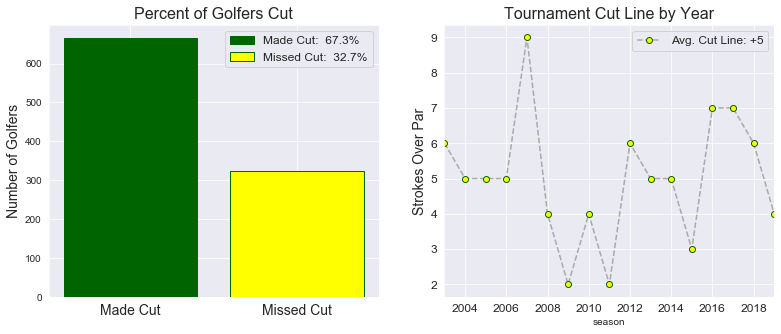

In [250]:
target_variable = 'made_cut'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Cut
height = df.groupby(target_variable).season.count().tolist()
missed_cut = height[0]
made_cut = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=made_cut,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Made Cut: {made_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Missed Cut: {missed_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.set_title("Percent of Golfers Cut", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Made Cut', 'Missed Cut'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper right', fontsize='large');

# Cutline overtime
avg_cutline = int(cut_lines['relative_to_par'].mean())
ax2 = fig.add_subplot(122);

cut_lines.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    color='darkgray',
    label=f'Avg. Cut Line: +{avg_cutline}'
);
ax2.set_title("Tournament Cut Line by Year", {'fontsize' : 16});
ax2.set_ylabel('Strokes Over Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');

In [252]:
top_10 = pd.DataFrame(df[df['top_10'] == 1].groupby('season').total_score.max())
top_10.reset_index(drop=False, inplace=True)
top_10['season'] = top_10['season']+1
top_10['relative_to_par'] = top_10['total_score']-(72*4)
top_10

,season,total_score,relative_to_par
0,2003,288.0,0.0
1,2004,286.0,-2.0
2,2005,285.0,-3.0
3,2006,286.0,-2.0
4,2007,295.0,7.0
5,2008,286.0,-2.0
6,2009,281.0,-7.0
7,2010,283.0,-5.0
8,2011,282.0,-6.0
9,2012,285.0,-3.0


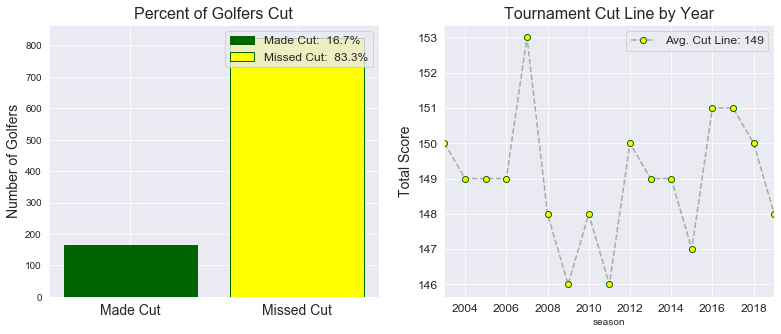

In [239]:
target_variable = 'top_10'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Cut
height = df.groupby(target_variable).season.count().tolist()
missed_cut = height[0]
made_cut = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=made_cut,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Made Cut: {made_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Missed Cut: {missed_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.set_title("Top 10 Summary", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Inside', 'Outside'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper left', fontsize='large');

# Cutline overtime
max_top10 = df.groupby('season').top_10.max()
ax2 = fig.add_subplot(122);

cut_lines.groupby('season').total_score.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    color='darkgray',
    label=f'Avg. Cut Line: {avg_cutline}'
);
ax2.set_title("Tournament Cut Line by Year", {'fontsize' : 16});
ax2.set_ylabel('Total Score', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');

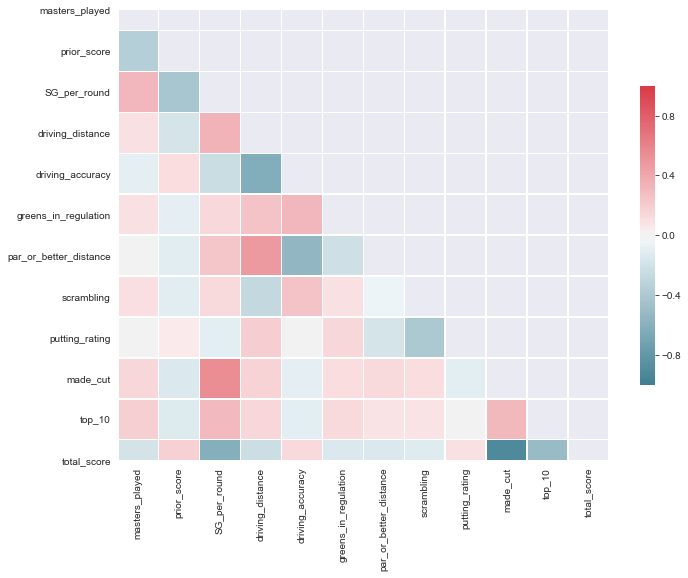

In [129]:
df_corr = df.drop(['season', 'full_name', 'min', 'mean'], axis=1)

fig = plt.figure(figsize=(11,11))

# Create mask
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = fig.add_subplot(111)
sns.heatmap(df_corr.corr(),
            mask=mask, 
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            ax=ax1);

## Visualizations by Feature

### Strokes Gained Per Round

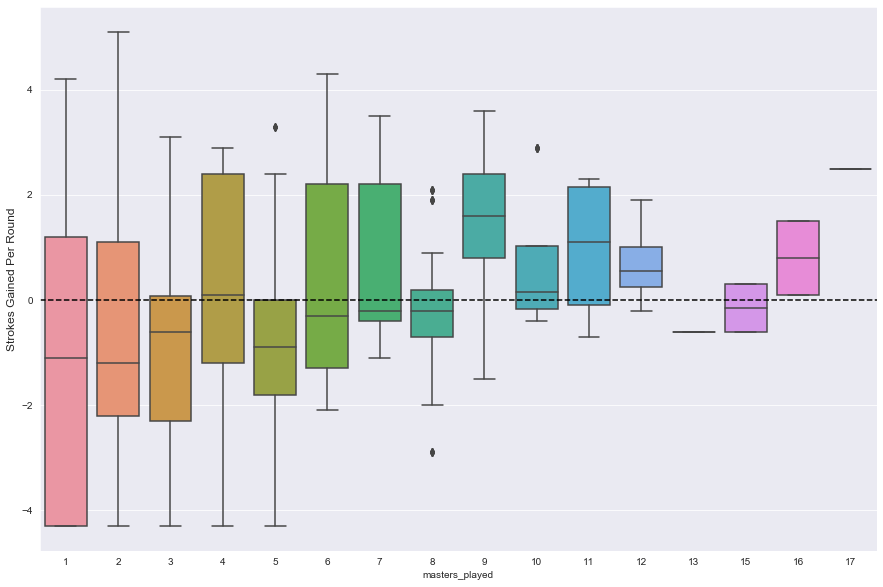

In [130]:
fig = plt.figure(figsize=figsize);
ax = fig.add_subplot(111);

sns.boxplot(
    x=df['masters_played'],
    y=df['SG_per_round']
);
ax.axhline(0, color='black', linestyle='--');
ax.set_ylabel('Strokes Gained Per Round', fontsize=12);

### Prior Score

In [80]:
# Only consider times after 2002 since no one has data prior
df_no_2002 = df[df['season'] != 2002]

# Define sub-dataframes for visualizations
made_cut = df_no_2002[df_no_2002['made_cut'] == 1]
missed_cut = df_no_2002[df_no_2002['made_cut'] == 0]
inside_top10 = df_no_2002[df_no_2002['top_10'] == 1]
outside_top10 = df_no_2002[df_no_2002['top_10'] == 0]

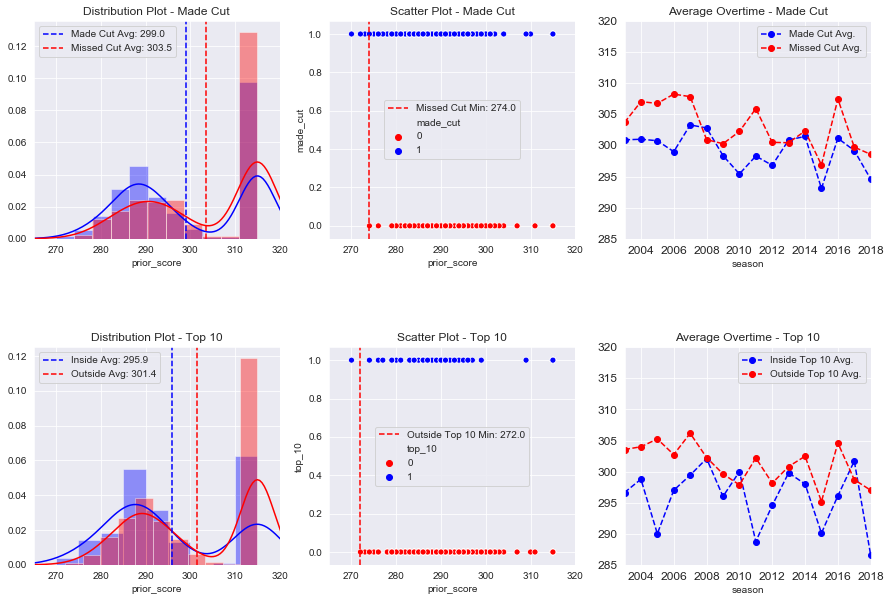

In [81]:
# Define universal Variables
feature = 'prior_score'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 265
xmax = 320
ymin = 285
ymax = 320
missed_cut_min = df_no_2002[df_no_2002['made_cut']==0][feature].min()
out_t10_min = df_no_2002[df_no_2002['top_10']==0][feature].min()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto',
    color='blue',
    ax=ax1
);
sns.distplot(
    missed_cut[feature],
    bins='auto',
    color='red',
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend();

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df_no_2002[feature],
    y=df_no_2002['made_cut'],
    hue=df_no_2002['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(missed_cut_min, linestyle = '--', color ='red', label=f'Missed Cut Min: {missed_cut_min}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend();

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend();

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df_no_2002[feature],
    y=df_no_2002['top_10'],
    hue=df_no_2002['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(out_t10_min, linestyle = '--', color ='red', label=f'Outside Top 10 Min: {out_t10_min}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.' 
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend();

### Driving Distance

In [82]:
#Re-define sub-dataframes for correct time period
made_cut = df[df['made_cut'] == 1]
missed_cut = df[df['made_cut'] == 0]
inside_top10 = df[df['top_10'] == 1]
outside_top10 = df[df['top_10'] == 0]

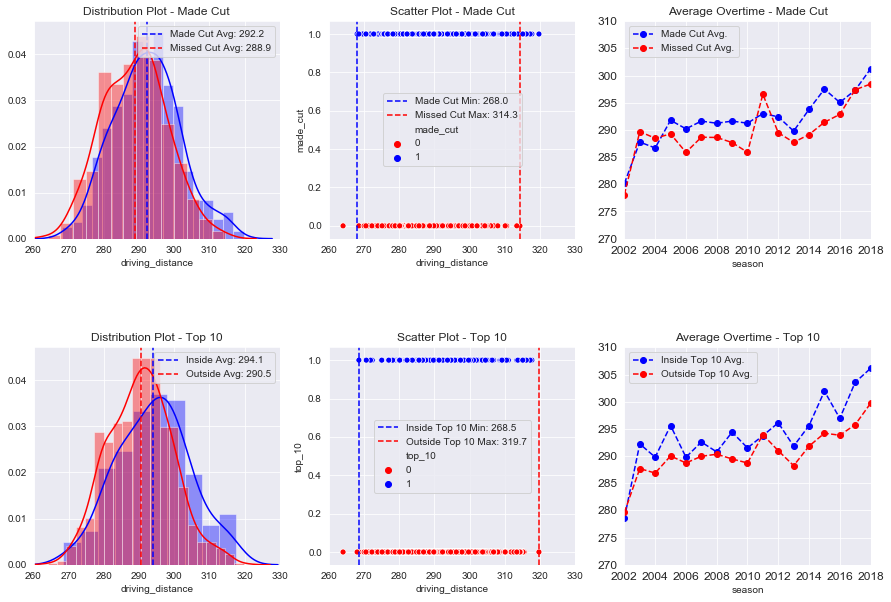

In [84]:
# Define universal Variables
feature = 'driving_distance'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 260
xmax = 330
ymin = 270
ymax = 310
made_cut_min = df[df['made_cut']==1][feature].min()
missed_cut_max = df[df['made_cut']==0][feature].max()
in_t10_min = df[df['top_10']==1][feature].min()
out_t10_max = df[df['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

### Driving Accuracy

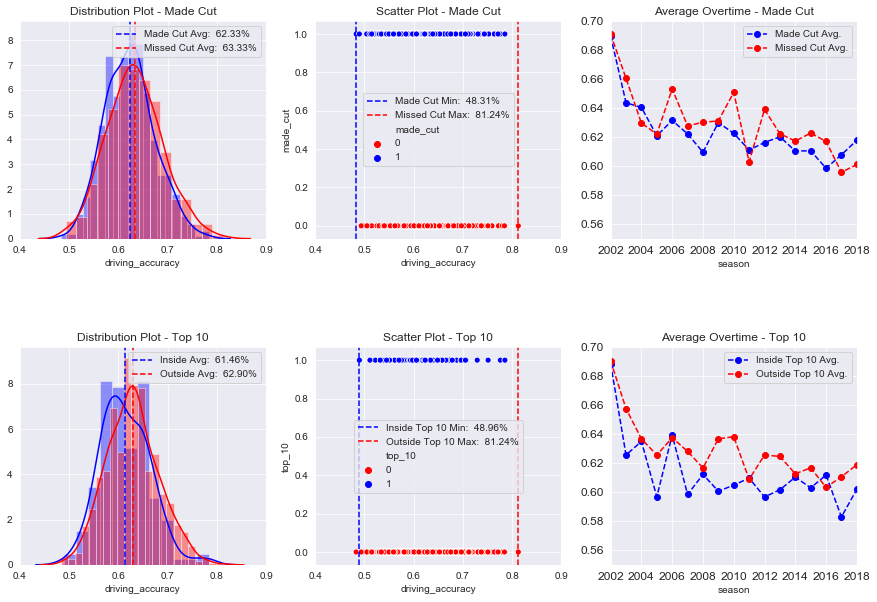

In [88]:
feature = 'driving_accuracy'
mean1_made = made_cut[feature].mean()
mean1_missed = missed_cut[feature].mean()
mean2_in = inside_top10[feature].mean()
mean2_out = outside_top10[feature].mean()
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0.4
xmax = 0.9
ymin = 0.55
ymax = 0.7
made_cut_min = df[df['made_cut']==1][feature].min()
missed_cut_max = df[df['made_cut']==0][feature].max()
in_t10_min = df[df['top_10']==1][feature].min()
out_t10_max = df[df['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made : 0.2%}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed : 0.2%}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min : 0.2%}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max : 0.2%}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper right');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in : 0.2%}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out : 0.2%}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min : 0.2%}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max : 0.2%}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper right');

### Greens in Regulation

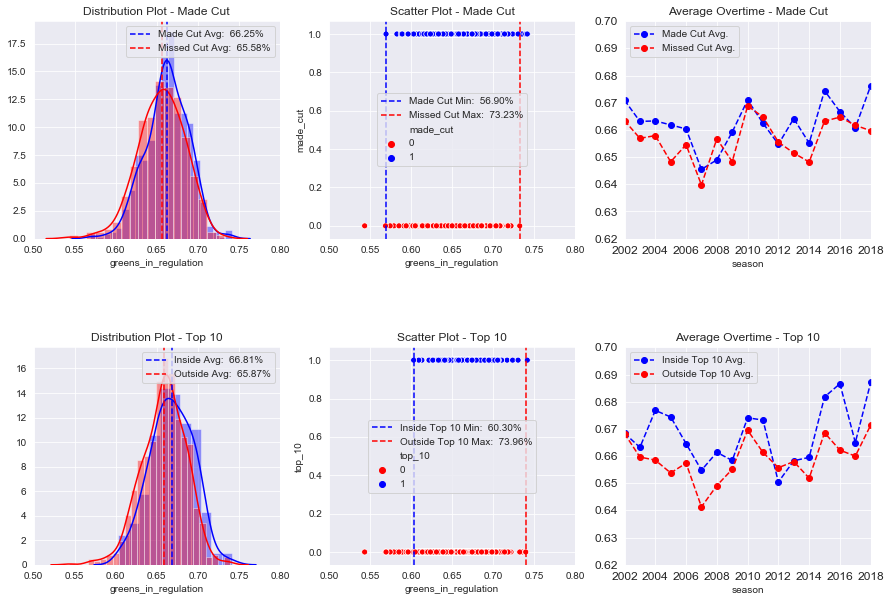

In [89]:
feature = 'greens_in_regulation'
mean1_made = made_cut[feature].mean()
mean1_missed = missed_cut[feature].mean()
mean2_in = inside_top10[feature].mean()
mean2_out = outside_top10[feature].mean()
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0.5
xmax = 0.8
ymin = 0.62
ymax = 0.7
made_cut_min = df[df['made_cut']==1][feature].min()
missed_cut_max = df[df['made_cut']==0][feature].max()
in_t10_min = df[df['top_10']==1][feature].min()
out_t10_max = df[df['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made : 0.2%}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed : 0.2%}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min : 0.2%}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max : 0.2%}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in : 0.2%}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out : 0.2%}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min : 0.2%}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max : 0.2%}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

### Par Or Better Distance

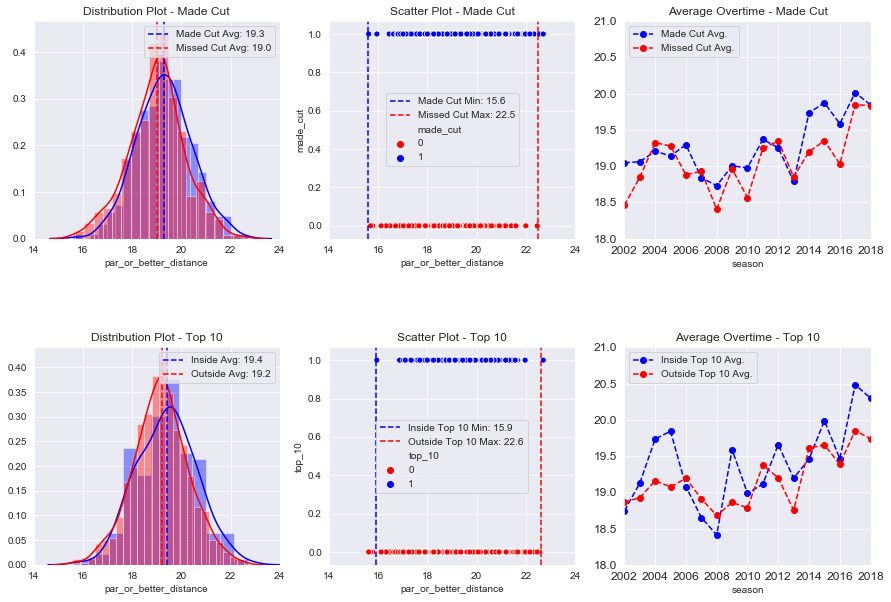

In [90]:
feature = 'par_or_better_distance'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 14
xmax = 24
ymin = 18
ymax = 21
made_cut_min = round(df[df['made_cut']==1][feature].min(), 1)
missed_cut_max = round(df[df['made_cut']==0][feature].max(), 1)
in_t10_min = round(df[df['top_10']==1][feature].min(), 1)
out_t10_max = round(df[df['top_10']==0][feature].max(), 1)

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

### Scrambling

In [72]:
# Drop the one scramling outlier
scram_only = df[(df['made_cut'] == 1) | ((df['made_cut'] == 0) & (df['scrambling'] < 0.68))]

#Redefine sub-dataframes for correct time period
made_cut = scram_only[scram_only['made_cut'] == 1]
missed_cut = scram_only[scram_only['made_cut'] == 0]
inside_top10 = scram_only[scram_only['top_10'] == 1]
outside_top10 = scram_only[scram_only['top_10'] == 0]

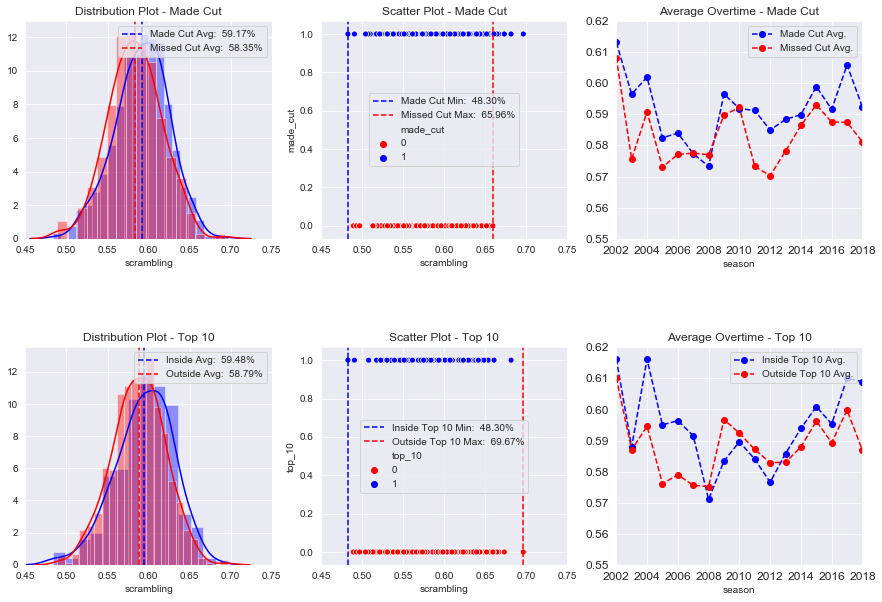

In [92]:
feature = 'scrambling'
mean1_made = made_cut[feature].mean()
mean1_missed = missed_cut[feature].mean()
mean2_in = inside_top10[feature].mean()
mean2_out = outside_top10[feature].mean()
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0.45
xmax = 0.75
ymin = 0.55
ymax = 0.62
made_cut_min = scram_only[scram_only['made_cut']==1][feature].min()
missed_cut_max = scram_only[scram_only['made_cut']==0][feature].max()
in_t10_min = scram_only[scram_only['top_10']==1][feature].min()
out_t10_max = scram_only[scram_only['top_10']==0][feature].max()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1, 
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1, 
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made : 0.2%}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed : 0.2%}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=scram_only[feature],
    y=scram_only['made_cut'],
    hue=scram_only['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_min, linestyle = '--', color ='blue', label=f'Made Cut Min: {made_cut_min : 0.2%}');
ax2.axvline(missed_cut_max, linestyle = '--', color ='red', label=f'Missed Cut Max: {missed_cut_max : 0.2%}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper right');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='blue', label=f'Inside Avg: {mean2_in : 0.2%}');
ax4.axvline(mean2_out, linestyle='--', color='red', label=f'Outside Avg: {mean2_out : 0.2%}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=scram_only[feature],
    y=scram_only['top_10'],
    hue=scram_only['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_min, linestyle = '--', color ='blue', label=f'Inside Top 10 Min: {in_t10_min : 0.2%}');
ax5.axvline(out_t10_max, linestyle = '--', color ='red', label=f'Outside Top 10 Max: {out_t10_max : 0.2%}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper right');

### Putting Rating

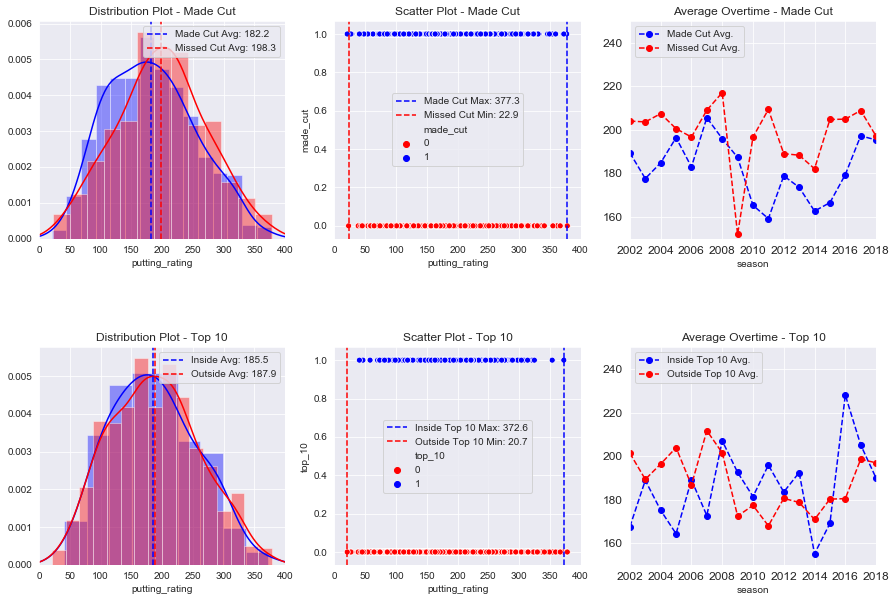

In [93]:
feature = 'putting_rating'
mean1_made = round(made_cut[feature].mean(), 1)
mean1_missed = round(missed_cut[feature].mean(), 1)
mean2_in = round(inside_top10[feature].mean(), 1)
mean2_out = round(outside_top10[feature].mean(), 1)
fig = plt.figure(figsize=figsize);
fig.subplots_adjust(hspace=hspace);
xmin = 0
xmax = 400
ymin = 150
ymax = 250
made_cut_max = df[df['made_cut']==1][feature].max()
missed_cut_min = df[df['made_cut']==0][feature].min()
in_t10_max = df[df['top_10']==1][feature].max()
out_t10_min = df[df['top_10']==0][feature].min()

# Made Cut - Dist Plot
ax1 = fig.add_subplot(231);
sns.distplot(
    made_cut[feature], 
    bins='auto', 
    color='blue', 
    ax=ax1
);
sns.distplot(
    missed_cut[feature], 
    bins='auto', 
    color='red', 
    ax=ax1
);
ax1.axvline(mean1_made, linestyle='--', color='blue', label=f'Made Cut Avg: {mean1_made}');
ax1.axvline(mean1_missed, linestyle='--', color='red', label=f'Missed Cut Avg: {mean1_missed}');
ax1.set_title('Distribution Plot - Made Cut');
ax1.set_xlim(xmin, xmax);
ax1.legend(loc='upper right');

# Made Cut - Scatter Plot
ax2 = fig.add_subplot(232);
sns.scatterplot(
    x=df[feature],
    y=df['made_cut'],
    hue=df['made_cut'],
    palette=['red', 'blue'],
    ax=ax2
);
ax2.axvline(made_cut_max, linestyle = '--', color ='blue', label=f'Made Cut Max: {made_cut_max}');
ax2.axvline(missed_cut_min, linestyle = '--', color ='red', label=f'Missed Cut Min: {missed_cut_min}');
ax2.set_title('Scatter Plot - Made Cut');
ax2.set_xlim(xmin, xmax);
ax2.legend(loc='center');

# Made Cut - Mean Overtime
ax3 = fig.add_subplot(233);
made_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Made Cut Avg.'
);
missed_cut.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax3,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Missed Cut Avg.'
);
ax3.set_title('Average Overtime - Made Cut', {'fontsize' : 12});
ax3.set_ylim(ymin, ymax);
ax3.legend(loc='upper left');

# Top 10 - Dist Plot
ax4 = fig.add_subplot(234);
sns.distplot(
    inside_top10[feature],
    bins='auto',
    color='blue',
    ax=ax4
);
sns.distplot(
    outside_top10[feature],
    bins='auto',
    color='red',
    ax=ax4
);
ax4.axvline(mean2_in, linestyle='--', color='b', label=f'Inside Avg: {mean2_in}');
ax4.axvline(mean2_out, linestyle='--', color='r', label=f'Outside Avg: {mean2_out}');
ax4.set_title('Distribution Plot - Top 10');
ax4.set_xlim(xmin, xmax);
ax4.legend(loc='upper right');

# Top 10 - Scatter Plot
ax5 = fig.add_subplot(235);
sns.scatterplot(
    x=df[feature],
    y=df['top_10'],
    hue=df['top_10'],
    palette=['red', 'blue'],
    ax=ax5
);
ax5.axvline(in_t10_max, linestyle = '--', color ='blue', label=f'Inside Top 10 Max: {in_t10_max}');
ax5.axvline(out_t10_min, linestyle = '--', color ='red', label=f'Outside Top 10 Min: {out_t10_min}');
ax5.set_title('Scatter Plot - Top 10');
ax5.set_xlim(xmin, xmax);
ax5.legend(loc='center');

# Top 10 - Mean Overtime
ax6 = fig.add_subplot(236);
inside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='blue',
    marker='o',
    linestyle='--',
    label='Inside Top 10 Avg.'
);
outside_top10.groupby(['season'])[feature].mean().plot(
    kind='line',
    ax=ax6,
    fontsize=12,
    color='red',
    marker='o',
    linestyle='--',
    label='Outside Top 10 Avg.'
);
ax6.set_title('Average Overtime - Top 10', {'fontsize' : 12});
ax6.set_ylim(ymin, ymax);
ax6.legend(loc='upper left');

# Modeling

## Load Data

In [ ]:
df = pd.read_csv('csv_files/noSG/final_golfer_data.csv', index_col=0)

print(df.shape)
df.head()

## Made Cut

### Define Key Variables

In [ ]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['missed_cut', 'made_cut']
FI_labels = df.drop(['season', 'full_name', 'min', 'mean', 'made_cut', 'top_10', 'total_score'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'accuracy'

### Train, Test, and Split

In [ ]:
X = df.drop(['season', 'full_name', 'min', 'mean', 'made_cut', 'top_10', 'total_score'], axis=1)
y = df['made_cut']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# We will use smote to handle our class imbalance
smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

### Standardization

In [ ]:
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Base Model

In [ ]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {
    'strategy' : [
        'stratified', 
        'most_frequent',
        'prior',
        'uniform',
        'constant'
    ]
}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

### Logistic Regression

In [ ]:
# Instantiate classifier and define model
classifier = LogisticRegression(random_state=SEED)
model_name = 'Logistic Regression Model'

# Create param grid for GridSearch
param_grid = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : np.logspace(-10, 10, 5),
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

### KNearest Neighbors (KNN)

In [ ]:
# Instantiate classifier and define model
classifier = KNeighborsClassifier()
model_name = 'KNN Model'

k = int(round(np.log(X_train.shape[0]), 0))

# Create param grid for GridSearch
param_grid = {'n_neighbors' : range(k,k+20,2)}

# Instantiate GridSearch
knn_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
knn_clf.fit(X_train, y_train)
y_hat_pred = knn_clf.predict(X_train)
y_pred = knn_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = knn_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/knn_model.pkl'
model = knn_clf
joblib.dump(model, filename)

### Decision Tree

In [ ]:
# Instantiate classifier and define model
classifier = DecisionTreeClassifier(random_state=SEED)
model_name = 'Decision Tree Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2, 5],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [5, 10]
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['criterion'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

### Random Forest

In [ ]:
# Instantiate classifier and define model
classifier = RandomForestClassifier(random_state=SEED)
model_name = 'Random Forest Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [50, 100],
    'max_depth' : [2, 5],
    'min_samples_split' : [5, 10],
    'min_samples_leaf' : [5, 10]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['criterion'],
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

### AdaBoost

In [ ]:
# Instantiate classifier and define model
classifier = AdaBoostClassifier(random_state=SEED)
model_name = 'AdaBoost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [50, 100],
    'learning_rate' : [0.1, 0.2, 0.5, 1]
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

### Gradient Boost

In [ ]:
# Instantiate classifier and define model
classifier = GradientBoostingClassifier(random_state=SEED)
model_name = 'Gradient Boost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [50],
    'learning_rate' : [0.01, 0.1, 0.2]
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

### Support Vector Machine

In [ ]:
# # Instantiate classifier and define model
# classifier = SVC(random_state=SEED)
# model_name = 'Support Vector Machine Model'

# # Create param grid for GridSearch
# param_grid = {
#     'C' : [0.1, 1, 10],
#     'kernel' : ['linear', 'rbf', 'sigmoid'],
#     'gamma' : [0.1, 1, 10]
# }

# # Instantiate GridSearch
# svm_clf = GridSearchCV(
#     classifier,
#     param_grid,
#     cv=cv,
#     scoring=scoring,
#     verbose=2,
#     n_jobs=-1
# )

# # Fit and make predictions
# svm_clf.fit(X_train, y_train)
# y_hat_pred = svm_clf.predict(X_train)
# y_pred = svm_clf.predict(X_test)

# # Print Best Params
# print('--'*27)
# print(f'{model_name} Best Params:')
# print('--'*27)
# best_params = svm_clf.best_params_
# keys = list(best_params.keys())
# for key in keys:
#     print(f"{key} : {best_params[key]}")

# # Print Precision Score
# p_hat = metrics.precision_score(y_train, y_hat_pred)
# p = metrics.precision_score(y_test, y_pred)
# print('--'*27)
# print(f'{model_name} Precision Scores:')
# print('--'*27)
# print(f' train: {p_hat : 0.2%}')
# print(f' test: {p : 0.2%}')

# # Print classification report
# print('--'*27)
# print(f'{model_name} Classification Report')
# print('--'*27)
# print(metrics.classification_report(y_test, y_pred, target_names=target_names))
# print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(svm_clf, X_test, y_test);

# # Pickle model
# filename = 'models/gb_model.pkl'
# model = gb_clf
# joblib.dump(model, filename)

### Results Summary

In [ ]:
classifiers = [dummy_clf, log_clf, knn_clf, dt_clf, rf_clf, ab_clf, gb_clf]
names = ['base', 'log_reg', 'knn', 'decTree', 'randomF', 'adaB', 'gradB']
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy_mc'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision_mc'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    results.append(result)

results_df = pd.DataFrame(results)

print(results_df.shape)
results_df

## Top 10

### Define Key Variables

In [ ]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['outside_top_10', 'inside_top_10']
FI_labels = df.drop(['season', 'full_name', 'min', 'mean', 'made_cut', 'top_10', 'total_score'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'accuracy'

class_weight = [
    'balanced',
    {0: 0.1, 1: 0.9},
    {0: 0.3, 1: 0.7},
    {0: 0.5, 1: 0.5}
]

### Train, Test, Split

In [ ]:
X = df.drop(['season', 'full_name', 'min', 'mean', 'made_cut', 'top_10', 'total_score'], axis=1)
y = df['top_10']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# # We will use smote to handle our class imbalance
# ros = ROS(random_state=SEED)
# X_train, y_train = ros.fit_resample(X_train, y_train)

### Standarization

In [ ]:
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

### Base Model

In [ ]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {
    'strategy' : [
        'stratified', 
        'most_frequent',
        'prior',
        'uniform',
        'constant'
    ]
}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

### Logistic Regression

In [ ]:
# Instantiate classifier and define model
classifier = LogisticRegression(random_state=SEED)
model_name = 'Logistic Regression Model'

# Create param grid for GridSearch
param_grid = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : np.logspace(-10, 10, 5),
    'class_weight': class_weight
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

### KNearest Neighbors (KNN)

In [ ]:
# Instantiate classifier and define model
classifier = KNeighborsClassifier()
model_name = 'KNN Model'

# Create param grid for GridSearch
param_grid = {
    'n_neighbors' : range(3,80,2),
    'weights' : ['uniform', 'distance']
}

# Instantiate GridSearch
knn_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
knn_clf.fit(X_train, y_train)
y_hat_pred = knn_clf.predict(X_train)
y_pred = knn_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = knn_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/knn_model.pkl'
model = knn_clf
joblib.dump(model, filename)

### Decision Tree

In [ ]:
# Instantiate classifier and define model
classifier = DecisionTreeClassifier(random_state=SEED)
model_name = 'Decision Tree Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 10),
    'min_samples_split' : range(5, 50, 5),
    'min_samples_leaf' : range(5, 50, 5),
    'class_weight' : class_weight
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# # Print confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# classes = target_names
# plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['criterion'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

### Random Forest

In [ ]:
# Instantiate classifier and define model
classifier = RandomForestClassifier(random_state=SEED)
model_name = 'Random Forest Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [100, 200],
    'max_depth' : [None, 2, 5, 10],
    'min_samples_split' : [2, 5],
    'min_samples_leaf' : [1, 5]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['criterion'],
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

### AdaBoost

In [ ]:
# Instantiate classifier and define model
classifier = AdaBoostClassifier(random_state=SEED)
model_name = 'AdaBoost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [100, 200, 500],
    'learning_rate' : [0.01, 0.1, 0.2, 0.5]
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

### Gradient Boost

In [ ]:
# Instantiate classifier and define model
classifier = GradientBoostingClassifier(random_state=SEED)
model_name = 'Gradient Boost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [100, 200, 500],
    'learning_rate' : [0.01, 0.1, 0.2, 0.5]
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

### Support Vector Machines

### Results Summary

In [ ]:
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    results.append(result)

results_df['accuracy_t10'] = 0.00
results_df['precision_t10'] = 0.00

for i in range(len(results)):
    results_df['accuracy_t10'].iloc[i] = results[i]['accuracy']
    results_df['precision_t10'].iloc[i] = results[i]['precision']

results_df

# Predicitons